In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer



#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

e:\anaconda\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#option flags
debug_mode = True
debug_output_n = 1

performance_log = True
data_log_csv_path = "training_log/simple_models.csv"

In [3]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_16_22_day.csv")

In [4]:
df = pd.read_csv(filename)

In [5]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600068.SH,20210901,9.50,10.13,9.35,9.93,9.35,0.58,6.2032,2251228.82,2202662.358
1,600068.SH,20210831,9.30,9.36,9.20,9.35,9.27,0.08,0.8630,860898.54,798131.416
2,600068.SH,20210830,9.28,9.60,9.24,9.27,9.23,0.04,0.4334,1196573.17,1120718.973
3,600068.SH,20210827,9.20,9.32,9.14,9.23,9.20,0.03,0.3261,740285.00,682613.418
4,600068.SH,20210826,9.40,9.68,9.09,9.20,9.30,-0.10,-1.0753,1558044.39,1453379.421
...,...,...,...,...,...,...,...,...,...,...,...
831628,600005.SH,20160108,3.42,3.63,3.40,3.63,3.30,0.33,10.0000,2623620.41,940783.297
831629,600005.SH,20160107,3.65,3.65,3.29,3.30,3.66,-0.36,-9.8400,433545.00,151466.196
831630,600005.SH,20160106,3.33,3.66,3.30,3.66,3.33,0.33,9.9100,2065794.86,739556.288
831631,600005.SH,20160105,3.18,3.41,3.14,3.33,3.23,0.10,3.1000,751018.19,247455.594


In [6]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
count,8.316330e+05,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,8.316330e+05,8.316330e+05
mean,2.019075e+07,30.046193,30.684832,29.469071,30.083063,30.062344,0.020719,0.049269,3.619721e+05,5.182667e+05
std,1.904651e+04,74.789339,76.308630,73.401426,74.899948,74.831898,2.434816,2.773921,7.258554e+05,9.041153e+05
min,2.016010e+07,0.170000,0.180000,0.160000,0.170000,0.170000,-209.990000,-36.877100,5.000000e+00,5.544000e+00
25%,2.017112e+07,6.560000,6.660000,6.460000,6.560000,6.560000,-0.150000,-1.200000,7.226044e+04,1.038375e+05
50%,2.019080e+07,13.200000,13.430000,13.000000,13.210000,13.210000,0.000000,0.000000,1.682014e+05,2.331566e+05
75%,2.021022e+07,28.120000,28.680000,27.660000,28.160000,28.150000,0.140000,1.143800,3.849387e+05,5.462001e+05
max,2.022082e+07,2587.980000,2627.880000,2485.000000,2601.000000,2601.000000,228.980000,306.108600,4.114453e+07,4.796717e+07


# Model DataFrame preprocessing

# add time periodicity

In [7]:
#split data into different stock
stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]
#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


In [8]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [9]:
if debug_mode:
    print(date_time_db[0])

304518   2016-01-04
304517   2016-01-05
304516   2016-01-06
304515   2016-01-07
304514   2016-01-08
            ...    
302905   2022-08-19
302904   2022-08-22
302903   2022-08-23
302902   2022-08-24
302901   2022-08-25
Name: trade_date, Length: 1618, dtype: datetime64[ns]


In [10]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [11]:
if debug_mode:
    date_time_stamp_db[0]

In [12]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

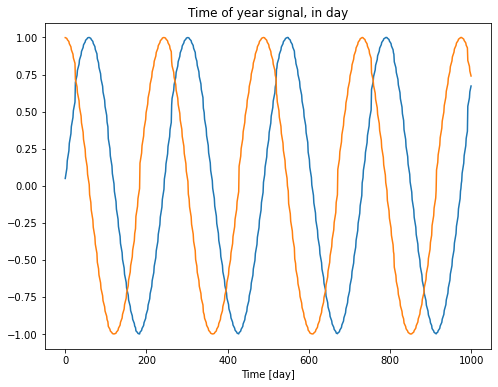

In [13]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [14]:
if debug_mode:
    stock_list[5].head()

In [15]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    stock.pop("pre_close") #pop previous day close price

In [16]:
if debug_mode:
    stock_list[0].head()

# Final data check

In [26]:
display(stock_list[0])
display(stock_list[50])

,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
304518,12.00,12.03,11.23,11.33,-0.66,-5.5000,563497.87,6.603762e+05,0.048922,0.998803
304517,11.27,11.57,11.15,11.40,0.07,0.6200,663269.95,7.555314e+05,0.066096,0.997813
304516,11.42,11.56,11.39,11.53,0.13,1.1400,515706.44,5.916985e+05,0.083251,0.996529
304515,11.41,11.41,10.91,10.94,-0.59,-5.1200,174761.10,1.948695e+05,0.100381,0.994949
304514,11.21,11.29,10.90,11.12,0.18,1.6500,747527.58,8.313345e+05,0.117481,0.993075
...,...,...,...,...,...,...,...,...,...,...
302905,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937
302904,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252
302903,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972
302902,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
162012,28.00,28.98,26.21,26.21,-2.91,-9.9900,181693.06,504117.7690,0.048922,0.998803
162011,24.80,27.18,24.15,25.64,-0.57,-2.1700,215141.51,552080.7469,0.066096,0.997813
162010,25.98,26.89,25.60,26.55,0.91,3.5500,143439.84,375328.7191,0.083251,0.996529
162009,26.00,26.08,23.90,23.90,-2.65,-9.9800,47600.50,118143.8995,0.100381,0.994949
162008,24.85,25.45,22.04,24.50,0.60,2.5100,229867.63,562135.5915,0.117481,0.993075
...,...,...,...,...,...,...,...,...,...,...
160427,15.05,15.14,14.82,14.82,-0.23,-1.5282,61757.68,92346.9190,-0.732342,-0.680937
160426,14.79,14.90,14.72,14.75,-0.07,-0.4723,47725.35,70567.6840,-0.766493,-0.642252
160425,14.79,15.03,14.70,14.84,0.09,0.6102,49639.05,73562.6530,-0.777428,-0.628972
160424,14.85,15.08,14.47,14.53,-0.31,-2.0889,83996.56,123999.9990,-0.788133,-0.615506


# Models Area

In [17]:
stacked_lstm_1 = Sequential(

    [

        LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1"

)

# Training for all models

In [18]:
#data storage
evaluation_result = {}


#meta data
labels = ['open']

eval_iteration = 10 #the number of evaluation iterations for individual stock

In [23]:
#main training loop
stock_training_range = 30 #len(stock_list)

for stock_index in range( 13,14 ):

    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.8  #percentage of train data
    val_data_p = 0.1

    train_df = current_stock[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]


    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std


    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    

    ##############################################################################################


    #chose model to run and evaluate
    train_target = win_7
    train_model = stacked_lstm_1



    #individual stock model performance evaluate 

    result = []

    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=20, es_patience=4, es_monitor='val_loss', es_mode='min')

        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    

    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)



    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]



    #data logging

    if performance_log == True:

        performance_log_csv = open(data_log_csv_path, 'a', encoding='UTF8', newline='')
        csv_writer = csv.writer(performance_log_csv)
        csv_writer.writerow([stock_list[stock_index].name, average_mape_val, average_mape_test, eval_iteration, len(train_df)])
        performance_log_csv.close()



Epoch 1/20
149/149 [==============================] - 5s 18ms/step - loss: 0.0054 - mean_absolute_percentage_error: 101.6009 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 7.0731
Epoch 2/20
149/149 [==============================] - 2s 13ms/step - loss: 0.0050 - mean_absolute_percentage_error: 103.7049 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 1.1365
Epoch 3/20
149/149 [==============================] - 2s 12ms/step - loss: 0.0054 - mean_absolute_percentage_error: 105.8368 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 6.9641
Epoch 4/20
149/149 [==============================] - 2s 13ms/step - loss: 0.0050 - mean_absolute_percentage_error: 115.8160 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 1.4197
Epoch 5/20
149/149 [==============================] - 2s 14ms/step - loss: 0.0049 - mean_absolute_percentage_error: 116.3399 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 8.9667
Epoch 6/20
149/149 [==============================] - 2

In [24]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()

Stock Model for :  000069.SZ
Average MAPE of val data_set :  49.29477500915527
Average MAPE of test data_set :  25.749573230743408

Stock Model for :  000100.SZ
Average MAPE of val data_set :  3.389886701107025
Average MAPE of test data_set :  119.90186309814453

Stock Model for :  000156.SZ
Average MAPE of val data_set :  3.4280005931854247
Average MAPE of test data_set :  3.3325767040252687



In [21]:

# header = ["stock_code","Average MAPE of val data_set", "Average MAPE of test data_set", "Iteration_number"]

# with open("training_log/simple_models.csv", 'w', encoding='UTF8', newline='') as file:

#     writer = csv.writer(file)

#     writer.writerow(header)

#     for key, value in evaluation_result.items():
#         writer.writerow([key, value[0], value[1]])